In [1]:
# Input info
exp <- "Flt3l"

# Saving
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/processed/mttrace/jan21_2021/MTblacklist/Flt3l" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000

#prefix <- "CHIP_april08_2021_Croker/MTblacklist/"
#external_dat_file <- "granja_10X_CD34.rds"
#external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/"

In [2]:
library(future)
plan()
#plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

In [3]:
source("/data2/mito_lineage/R_scripts/annotations/01_CD34_projection.R")

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [4]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(cowplot)

library(magrittr)

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: AnnotationFilter


Attaching package: ‘AnnotationFilter’


The following object is masked from ‘package:future’:

    value



Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:stats':

    filter



Attaching package: 'patchwork'


The following object is masked from 'package:MASS':

    area



Attaching package: 'data.table'


The following objects are ma

## Import data

In [6]:
combined <- readRDS(file.path(outdir, paste0(exp, ".merged.rds")))

In [7]:
varPeaks <- (VariableFeatures(combined[["ATAC"]]))

In [8]:
ext <- subset(x = combined, subset = orig.ident == "granja_cd34")
curr <- subset(x = combined, subset = orig.ident == exp)


In [9]:
# Subset on varPeaks in both 
varPeaks_both <- rownames(ext)[(varPeaks %in% rownames(ext)) & (varPeaks %in% rownames(curr))]
length(varPeaks_both)
#curr_varP <- rownames(curr)[varPeaks]


[1] 656151

In [10]:
ext_var <- GetAssayData(ext)[varPeaks_both,]
dim(ext_var)

[1] 656151   2196

In [11]:
curr_var <- GetAssayData(curr)[varPeaks_both,]
dim(curr_var)

[1] 656151  12009

# Run the workflow - Using our dataset as reference and projecting external data onto our coordinates

## 1. Run LSI 1st Iteration

In [14]:
lsi1 <- calcLSI(curr[["ATAC"]]@data, nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust1 <- louvainIgraphClusters(lsi1[[1]], 10)



Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



## 2. Make Pseudo Bulk Library


In [15]:
message("Making PseudoBulk...")
clusterSums <- groupSums(mat = curr[["ATAC"]]@data, groups = clust1) #Group Sums
logMat <- edgeR::cpm(clusterSums, log = TRUE, prior.count = 3) #log CPM matrix
varPeaks <- head(order(matrixStats::rowVars(logMat), decreasing = TRUE), nTop) #Top variable peaks
dim(varPeaks)

Making PseudoBulk...



NULL

## 3. Run LSI 2nd Iteration

In [16]:
lsi2 <- calcLSI(curr[["ATAC"]]@data[varPeaks,,drop=FALSE], nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust2 <- louvainIgraphClusters(lsi2[[1]][,c(2:25)], 30)
print("Number of clusters")
print(length(unique(clust2)))
print("LSI2 dimensions")
print(dim(lsi2$matSVD))


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



[1] "Number of clusters"
[1] 11
[1] "LSI2 dimensions"
[1] 12009    25


### 3.2 build mean for clusters

In [17]:
means_lsi <- build_means_for_clusters(lsi2$matSVD, clust2)
lsiPeaks <- varPeaks
lsiReference <- lsi2


## 4. Run UMAP on 2nd LSI

In [18]:
set.seed(1)
umap <- umap::umap(
  lsi2$matSVD[,2:25], 
  n_neighbors = 55, # original 55
  min_dist = 0.45, # original 0.45
  metric = "cosine", 
  verbose = TRUE    )
#set.seed(10)

[2021-07-30 01:21:01]  starting umap

[2021-07-30 01:21:01]  creating graph of nearest neighbors

[2021-07-30 01:24:51]  creating initial embedding

[2021-07-30 01:24:56]  optimizing embedding

[2021-07-30 01:25:51]  done



## 4.2 Build UMAP means for each cluster

In [19]:
umap_clust2 <- louvainIgraphClusters(umap$layout, k = 100)
length(unique(umap_clust2))
umap_means_lsi <- build_means_for_clusters(umap$layout, umap_clust2)

[1] 16

## 5. Project external data to our samples LSI-embedded coordinate system

In [20]:
lsiProjection <- projectLSI(ext[["ATAC"]]@data[varPeaks,,drop=FALSE], lsi2)


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



## Remove any 0 cells

In [21]:
noZero.inds <- names(which(!((apply(data.matrix(lsiProjection[,2:25]==0),MARGIN=1, all)))))
umapProjection <- round(predict(umap, data.matrix(lsiProjection[noZero.inds,2:25])), 2)
#umapProjection <- round(predict(umap, data.matrix(lsiProjection[,2:25])), 2)

[2021-07-30 01:26:04]  creating graph of nearest neighbors

[2021-07-30 01:29:41]  creating initial embedding

[2021-07-30 01:29:41]  optimizing embedding

[2021-07-30 01:29:46]  done



## 6. Plot our clustered results

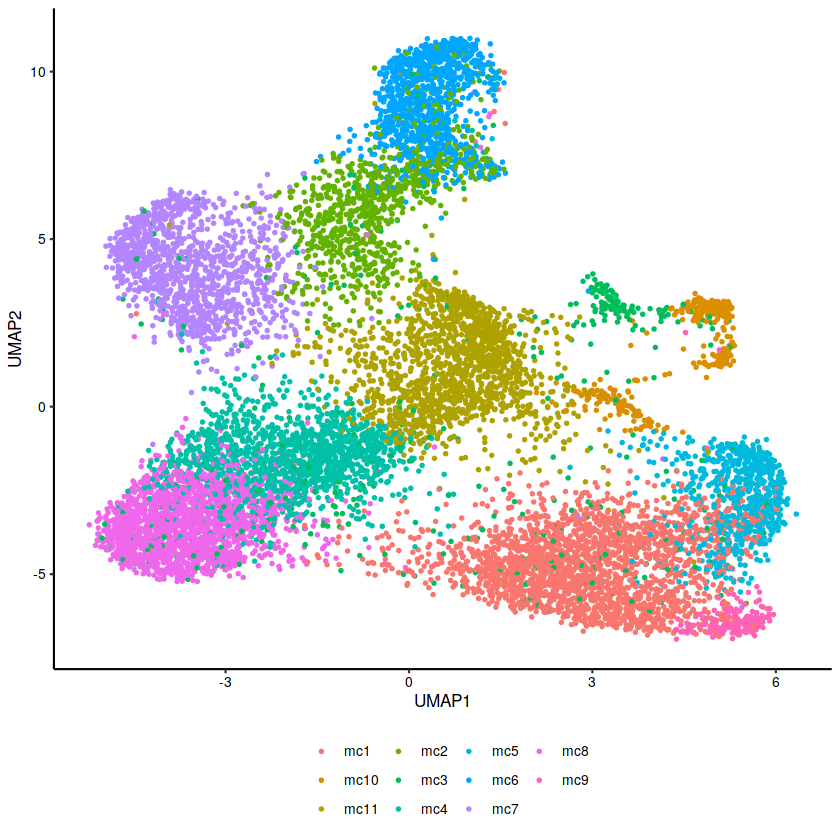

In [22]:
# Multiply by -1 to make the pseudotime read left to right
plot_df <- data.frame(umap$layout*-1, (curr[[]]), Clusters = clust2)

p0 <- ggplot(plot_df, aes(x= X1, y = X2, color = Clusters)) +
   geom_point(size = 0.5) +
   labs(x = "UMAP1", y= "UMAP2", color = "") +
  pretty_plot() + L_border() + theme(legend.position = "bottom")

print(p0)
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".merged.lsi.Batchlabels.png")), width = 1.7, height = 1.7)

## 7. Project the external data and plot it's UMAP coordinates

In [24]:
projection_df <- data.frame(
  celltype = c(gsub("BM_", "", (ext[[]])[rownames(umapProjection),]$Group), rep("none", dim(plot_df)[1])),
  umap1 = c(umapProjection[,1]*-1, plot_df$X1),
  umap2 = c(umapProjection[,2]*-1, plot_df$X2)
)


Warning message:
"Removed 122 rows containing missing values (geom_point)."


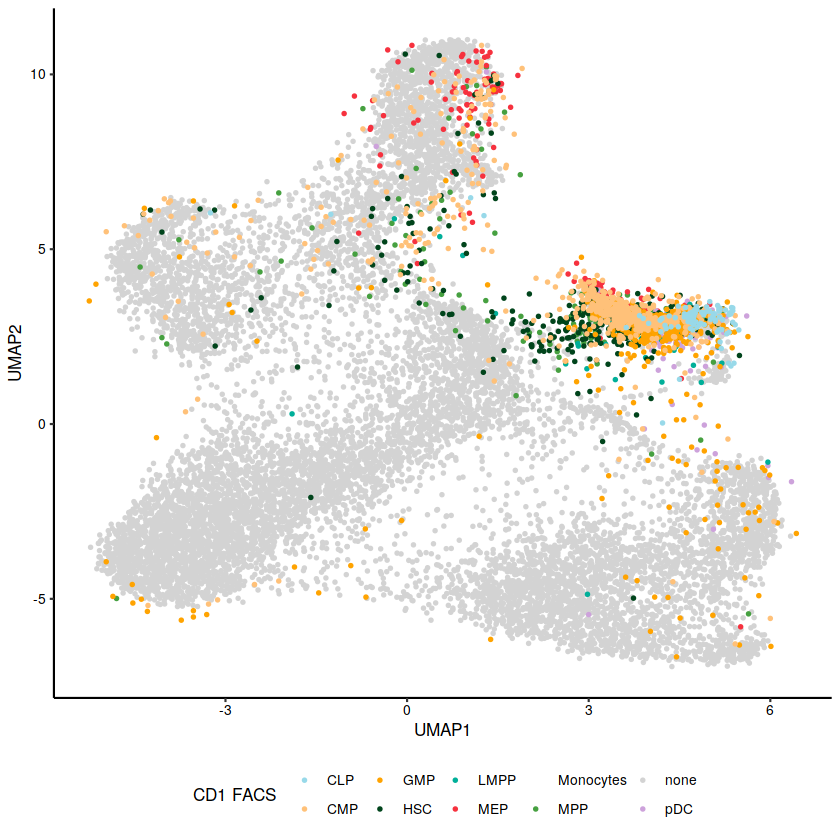

In [25]:
p1 <- ggplot(projection_df[dim(projection_df)[1]:1,], aes(x= umap1, y = umap2, color = celltype, label = celltype)) +
  geom_point(size = 0.5) +
  labs(x = "UMAP1", y= "UMAP2", color = "CD1 FACS ") +
  pretty_plot() + L_border() + theme(legend.position = "bottom") +
  scale_color_manual(values = c(ejc_color_maps, "none" = "lightgrey"))#, "Monocytes" = "orange2")) 
print(p1)

cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".project.ext.cellLabels.png")), width = 1.7, height = 1.7)


## 8. LSI classify from the reference projected into sample space
(Also try the umap project and classify

In [26]:
## Classifying each cluster to nearest reference cell
use_means <- FALSE
if(use_means){
    projected_clustersbasic <- classify_from_reference(data.matrix(lsiProjection)[rownames(umapProjection),1:25],t(means_lsi)[,1:25])    
}else{
    ## Classifying each cell to nearest reference cell.
    projected_clustersbasic <- classify_from_reference(data.matrix(lsiProjection)[rownames(umapProjection),1:25],
                                                   (lsi2$matSVD)[,1:25])    
}
head(projected_clustersbasic)


                                                   



[1] "ext_GMP#BM1214_GMP_160421_55"              
[2] "ext_CMP#160822_BM1137_CMP_LS_16"           
[3] "ext_CMP#160822_BM1137_CMP_LS_92"           
[4] "ext_GMP#160809_scATAC_BM1137_GMP1low_LS_85"
[5] "ext_CMP#BM1077_CMP_Frozen_160106_93"       
[6] "ext_GMP#160809_scATAC_BM1137_GMP1low_LS_41"

In [27]:
#annovec <- c("myeloid", "myeloid", "CD4", "CD4", "Bcell", "CD8", "myeloid", "myeloid", "myeloid", "NKcell", "CD4", "CD8", "Bcell")
annovec <- ext[["Group"]]
#names(annovec) <- paste0("mc", as.character(1:13))
projected_clusters <- annovec[as.character(projected_clustersbasic),]
projected_clusters
curr[["predict"]] <- projected_clusters

group_or_pred <- function(x){
    if (is.na(x["Group"])){
      return(x["predict"])
    }
    return(x["Group"])
    
    }
curr[["group_or_predict"]] <- apply(curr[[]], MARGIN=1, group_or_pred)

[1] "GMP"       "CMP"       "CMP"       "GMP"       "CMP"       "GMP"      
    [7] "MEP"       "CMP"       "GMP"       "MEP"       "GMP"       "GMP"      
   [13] "GMP"       "GMP"       "GMP"       "CMP"       "GMP"       "BM_pDC"   
   [19] "MEP"       "GMP"       "CMP"       "GMP"       "MEP"       "Monocytes"
   [25] "GMP"       "BM_pDC"    "BM_pDC"    "GMP"       "BM_pDC"    "GMP"      
   [31] "MEP"       "GMP"       "GMP"       "CMP"       "GMP"       "MEP"      
   [37] "GMP"       "GMP"       "MEP"       "MEP"       "MEP"       "GMP"      
   [43] "GMP"       "GMP"       "GMP"       "GMP"       "CLP"       "GMP"      
   [49] "Monocytes" "GMP"       "BM_pDC"    "CMP"       "BM_pDC"    "MEP"      
   [55] "GMP"       "MEP"       "GMP"       "GMP"       "Monocytes" "GMP"      
   [61] "GMP"       "GMP"       "Monocytes" "CMP"       "GMP"       "CMP"      
   [67] "GMP"       "CMP"       "CMP"       "CMP"       "GMP"       "CMP"      
   [73] "GMP"       "BM_pDC"    "CMP"       "CMP"       "CMP"       "Monocytes"
   [79] "MEP"       "BM_pDC"    "GMP"       "CMP"       "MEP"       "GMP"      
   [85] "GMP"       "GMP"       "HSC"       "CMP"       "CLP"       "Monocytes"
   [91] "BM_pDC"    "GMP"       "BM_pDC"    "CMP"       "GMP"       "GMP"      
   [97] "GMP"       "CMP"       "GMP"       "CMP"       "GMP"       "GMP"      
  [103] "GMP"       "CMP"       "GMP"       "MPP"       "MEP"       "CMP"      
  [109] "CMP"       "CMP"       "Monocytes" "GMP"       "BM_pDC"    "BM_pDC"   
  [115] "GMP"       "GMP"       "GMP"       "GMP"       "GMP"       "MEP"      
  [121] "GMP"       "GMP"       "GMP"       "CMP"       "Monocytes" "GMP"      
  [127] "GMP"       "GMP"       "MEP"       "CMP"       "BM_pDC"    "CMP"      
  [133] "GMP"       "Monocytes" "GMP"       "GMP"       "CMP"       "Monocytes"
  [139] "GMP"       "CMP"       "CMP"       "HSC"       "GMP"       "CMP"      
  [145] "GMP"       "GMP"       "GMP"       "CMP"       "GMP"       "GMP"      
  [151] "Monocytes" "GMP"       "GMP"       "BM_pDC"    "GMP"       "GMP"      
  [157] "Monocytes" "GMP"       "GMP"       "GMP"       "BM_pDC"    "HSC"      
  [163] "GMP"       "GMP"       "CMP"       "GMP"       "HSC"       "GMP"      
  [169] "GMP"       "CMP"       "GMP"       "GMP"       "MEP"       "GMP"      
  [175] "GMP"       "GMP"       "CMP"       "GMP"       "GMP"       "BM_pDC"   
  [181] "HSC"       "HSC"       "CMP"       "CMP"       "GMP"       "MEP"      
  [187] "MEP"       "GMP"       "GMP"       "CMP"       "CMP"       "GMP"      
  [193] "GMP"       "GMP"       "HSC"       "CMP"       "MEP"       "Monocytes"
  [199] "CMP"       "BM_pDC"    "GMP"       "GMP"       "BM_pDC"    "GMP"      
  [205] "GMP"       "CMP"       "CMP"       "GMP"       "CMP"       "CMP"      
  [211] "BM_pDC"    "GMP"       "CMP"       "CMP"       "GMP"       "GMP"      
  [217] "GMP"       "GMP"       "BM_pDC"    "GMP"       "GMP"       "CMP"      
  [223] "GMP"       "GMP"       "BM_pDC"    "GMP"       "BM_pDC"    "GMP"      
  [229] "GMP"       "Monocytes" "GMP"       "GMP"       "MPP"       "BM_pDC"   
  [235] "CMP"       "Monocytes" "GMP"       "GMP"       "CMP"       "HSC"      
  [241] "CLP"       "MEP"       "CMP"       "CMP"       "Monocytes" "GMP"      
  [247] "GMP"       "GMP"       "GMP"       "GMP"       "CMP"       "BM_pDC"   
  [253] "Monocytes" "BM_pDC"    "HSC"       "BM_pDC"    "CMP"       "CMP"      
  [259] "CMP"       "GMP"       "GMP"       "GMP"       "CMP"       "MEP"      
  [265] "HSC"       "CMP"       "MPP"       "CMP"       "GMP"       "GMP"      
  [271] "BM_pDC"    "CMP"       "HSC"       "GMP"       "Monocytes" "GMP"      
  [277] "GMP"       "CMP"       "CMP"       "GMP"       "GMP"       "CMP"      
  [283] "HSC"       "CMP"       "HSC"       "CLP"       "CMP"       "GMP"      
  [289] "Monocytes" "GMP"       "CMP"       "BM_pDC"    "GMP"       "GMP"      
  [295] "MEP"       "CMP"       "MEP"       "GMP"       "CMP"       "MEP"      
  [3

In [28]:
curr[["group_or_predict"]] <- apply(curr[[]], MARGIN=1, group_or_pred)

In [29]:
plot_df <- data.frame(umap$layout*-1, (curr[[]]), Clusters = clust2)
projection_df <- data.frame(
  celltype = c(gsub("BM_", "", (ext[[]])[rownames(umapProjection),]$Group), 
               plot_df[,"group_or_predict"]),
  umap1 = c(umapProjection[,1]*-1, plot_df$X1),
  umap2 = c(umapProjection[,2]*-1, plot_df$X2)
)
head(projection_df)

,celltype,umap1,umap2
,<chr>,<dbl>,<dbl>
1,Monocytes,5.21,-2.35
2,Monocytes,4.28,2.08
3,Monocytes,3.94,3.02
4,Monocytes,3.74,2.75
5,Monocytes,4.42,2.06
6,Monocytes,4.58,2.32


## 9. Plot both annotated cell from external and predicted cell type in our sample overlaid on UMAP

Warning message:
"Removed 847 rows containing missing values (geom_point)."


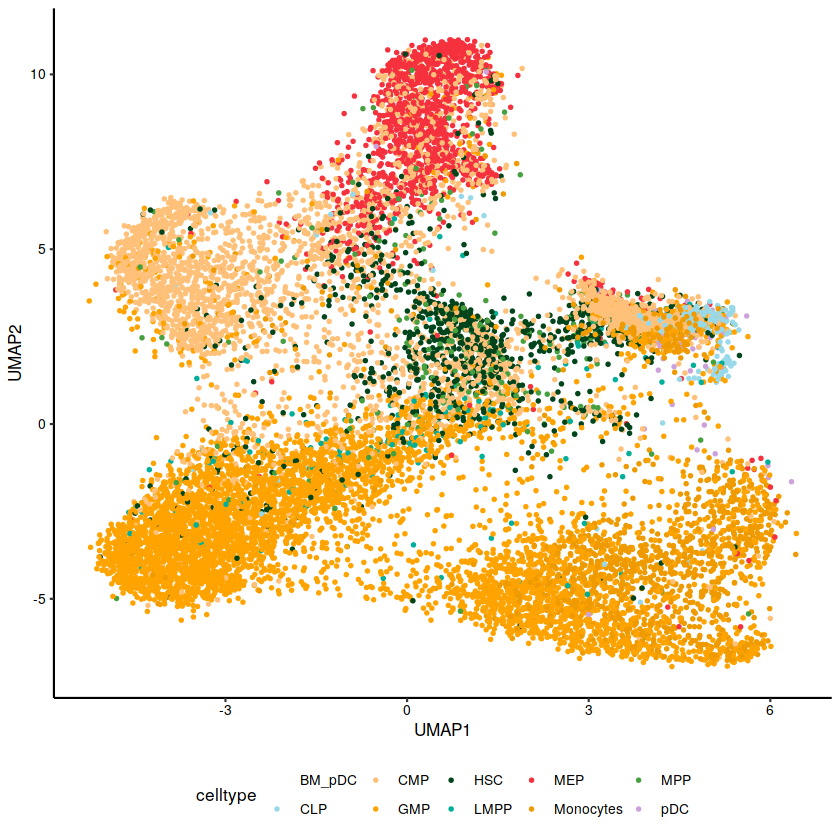

In [30]:
p1 <- ggplot(projection_df[dim(projection_df)[1]:1,], aes(x= umap1, y = umap2, color = celltype, label = celltype)) +
  geom_point(size = 0.5) +
  labs(x = "UMAP1", y= "UMAP2", color="celltype") +
  pretty_plot() + L_border() + theme(legend.position = "bottom") +
  scale_color_manual(values = c(ejc_color_maps, "none" = "lightgrey","Monocytes" = "orange2")) 
print(p1)

cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".project.cellLabels.png")), width = 1.7, height = 1.7)


## 10. Plot predicted cell type of our sample overlaid on UMAP

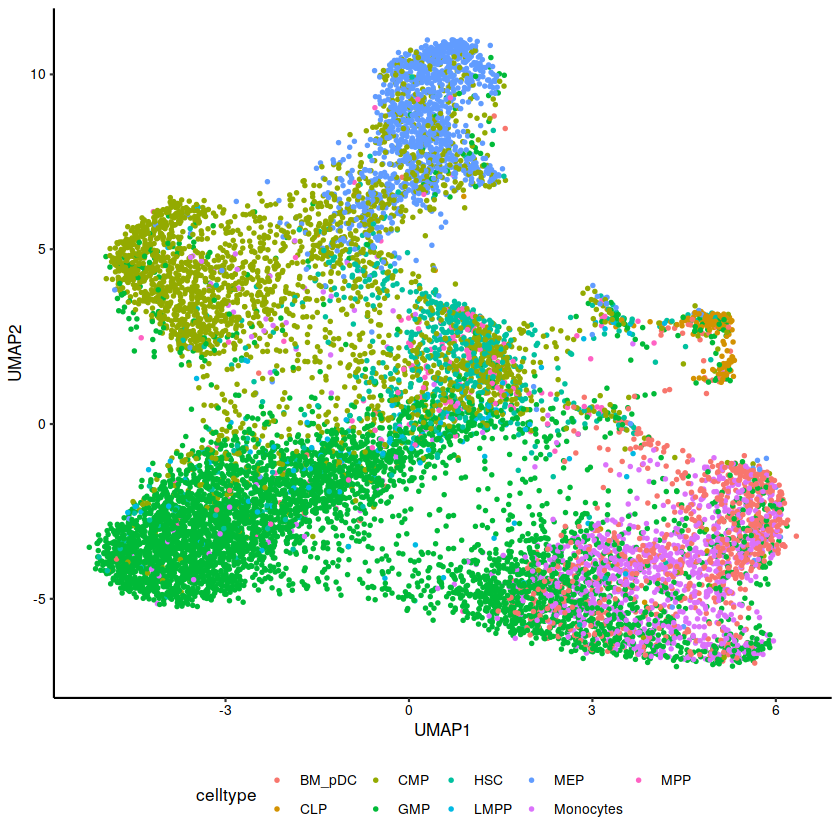

In [31]:
# Multiply by -1 to make the pseudotime read left to right
plot_df <- data.frame(umap$layout*-1, (curr[[]]))

p0 <- ggplot(plot_df, aes(x= X1, y = X2, color = group_or_predict)) +
   geom_point(size = 0.5) +
   labs(x = "UMAP1", y= "UMAP2", color = "celltype") +
  pretty_plot() + L_border() + theme(legend.position = "bottom")


print(p0)
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".project.sample.cellLabels.umap.png")), width = 1.7, height = 1.7)


## 11. Plot predicted cell type abundance 

          predict
orig.ident BM_pDC  CLP  CMP  GMP  HSC LMPP  MEP Monocytes  MPP
     Flt3l    847  157 2595 5139  699  134 1214      1067  157

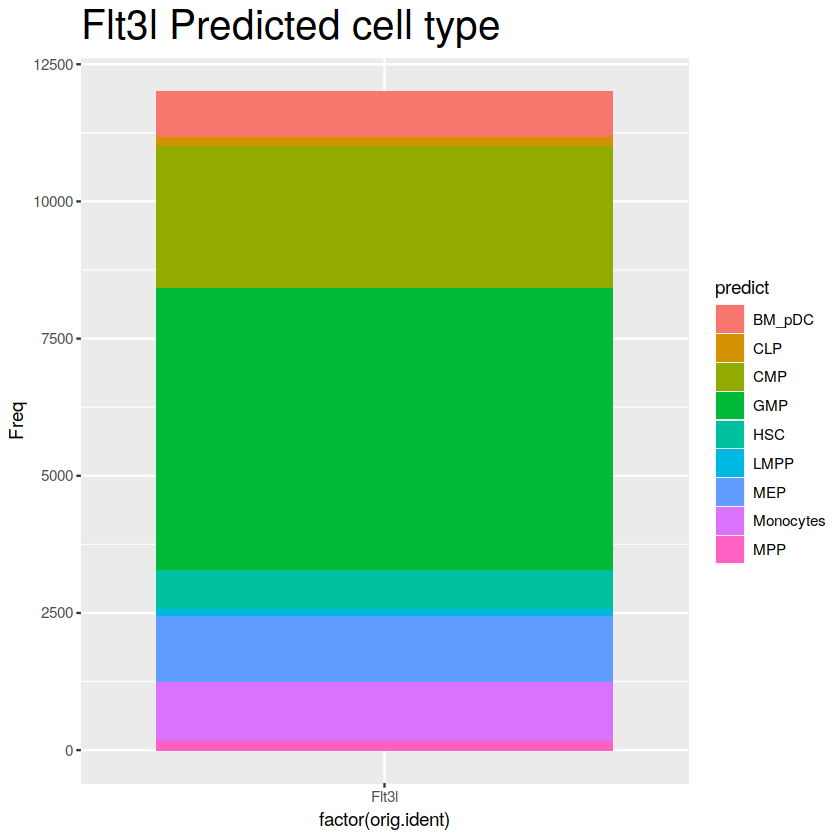

In [32]:
tbl <- with(plot_df, table(orig.ident, predict))
tbl
ggplot(as.data.frame(tbl), aes(factor(orig.ident), Freq, fill = predict)) +
    geom_bar(position = 'stack', stat='identity') +
    ggtitle(paste(exp, "Predicted cell type")) + 
    theme(plot.title=element_text(size=24))
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".project.sample.cellLabels.abundace.png")), width = 1.7, height = 1.7)


## Plot abundance for external data

          predict
orig.ident BM_pDC  CLP  CMP  GMP  HSC LMPP  MEP Monocytes  MPP
     Flt3l    847  157 2595 5139  699  134 1214      1067  157

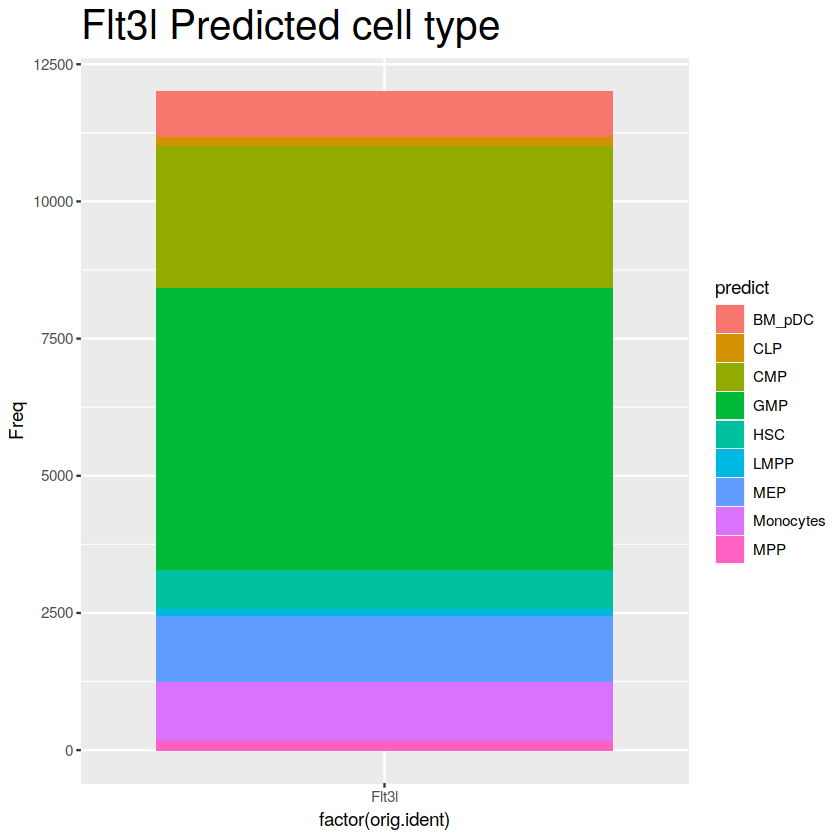

In [32]:
ext_df <- data.frame(umap$layout*-1, (ext[[]]))

tbl <- with(ext_df, table(orig.ident, group_or_predict))
tbl
ggplot(as.data.frame(tbl), aes(factor(orig.ident), Freq, fill = group_or_predict)) +
    geom_bar(position = 'stack', stat='identity') +
    ggtitle(paste(exp, "Predicted cell type")) + 
    theme(plot.title=element_text(size=24))
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".project.ext.cellLabels.abundace.png")), width = 1.7, height = 1.7)


## Save LSI projection results and cluster results

In [33]:
write.table(projection_df, file = file.path(outdir, paste0(exp, ".extProjection.txt")), quote=F)

In [34]:
write.table(plot_df, file = file.path(outdir, paste0(exp, "_umapProjection.txt")),quote=F)

In [35]:
write.table(plot_df[, "predict", drop=FALSE], file = file.path(outdir, paste0(exp, ".clusters.csv")), col.names=FALSE,
          row.names=TRUE, quote=FALSE, sep=",")

## Save a barcode,cluster csv file to be used for 10x Loupe browser.

In [36]:
init_bc <- function(x){
    x <- unlist(stringr::str_split(x, pattern="_", simplify = T))
    return(as.character(x[2]))
}
plot_df$BC <- sapply(as.character(rownames(plot_df)), init_bc)
plot_df
                        

,X1,X2,orig.ident,nCount_ATAC,nFeature_ATAC,Group,proj,predict,group_or_predict,BC
,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
Flt3l_AAACGAAAGAGCTCCC-1,-2.7197704,-3.7303126,Flt3l,6303,6303,NA,Flt3l,GMP,GMP,AAACGAAAGAGCTCCC-1
Flt3l_AAACGAAAGCGATACG-1,0.5737681,0.2086076,Flt3l,2527,2527,NA,Flt3l,CMP,CMP,AAACGAAAGCGATACG-1
Flt3l_AAACGAAAGGCTTCGC-1,0.1295745,9.0112448,Flt3l,4970,4970,NA,Flt3l,CMP,CMP,AAACGAAAGGCTTCGC-1
Flt3l_AAACGAAAGTACAACA-1,-2.4537385,-0.8119378,Flt3l,1795,1795,NA,Flt3l,GMP,GMP,AAACGAAAGTACAACA-1
Flt3l_AAACGAACAACGTACT-1,-0.8374407,5.8950487,Flt3l,3527,3527,NA,Flt3l,CMP,CMP,AAACGAACAACGTACT-1
Flt3l_AAACGAACAAGCGGTA-1,-1.6182958,-1.4661288,Flt3l,1672,1672,NA,Flt3l,GMP,GMP,AAACGAACAAGCGGTA-1
Flt3l_AAACGAACACCTGGTG-1,0.5426308,10.5521532,Flt3l,3548,3548,NA,Flt3l,MEP,MEP,AAACGAACACCTGGTG-1
Flt3l_AAACGAACACGATATC-1,-2.9552679,3.6665571,Flt3l,3037,3037,NA,Flt3l,CMP,CMP,AAACGAACACGATATC-1
Flt3l_AAACGAACACTTACAG-1,5.1337690,-5.8502657,Flt3l,11648,11648,NA,Flt3l,GMP,GMP,AAACGAACACTTACAG-1


In [37]:
write.table(plot_df[, c("BC", "predict"), drop=FALSE], file = file.path(outdir, paste0(exp, ".clusters.BC.csv")), col.names=FALSE,
          row.names=FALSE, quote=FALSE, sep=",")

In [38]:
file.path(outdir, paste0(exp, ".clusters.BC.txt"))

[1] "/data2/mito_lineage/Analysis/annotation/output/data/processed/mttrace/jan21_2021/MTblacklist/Flt3l/Flt3l.clusters.BC.txt"